




















# Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import collections
import pathlib
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

2023-04-04 14:49:38.994220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 14:49:39.518929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Transfer Learning via VVG19 and InceptionV3
## 1.VGG19
#### 1.1 Load dataset

In [ ]:
dataset_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

#### 1.2  Data Preprocessing

In [ ]:
data_dir = "Images/"  ## Dataset directory
img_width, img_height = 224, 224 
channels = 3
batch_size = 64

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)   

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [ ]:
class_names = train_ds.class_names ### classes' name

In [ ]:
classes = []
for name in class_names:
    classes.append(name.split('-')[1])  ### To collect all classes' name in one list

In [ ]:
classes

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Shih',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'black',
 'Walker_hound',
 'English_foxhound',
 'redbone',
 'borzoi',
 'Irish_wolfhound',
 'Italian_greyhound',
 'whippet',
 'Ibizan_hound',
 'Norwegian_elkhound',
 'otterhound',
 'Saluki',
 'Scottish_deerhound',
 'Weimaraner',
 'Staffordshire_bullterrier',
 'American_Staffordshire_terrier',
 'Bedlington_terrier',
 'Border_terrier',
 'Kerry_blue_terrier',
 'Irish_terrier',
 'Norfolk_terrier',
 'Norwich_terrier',
 'Yorkshire_terrier',
 'wire',
 'Lakeland_terrier',
 'Sealyham_terrier',
 'Airedale',
 'cairn',
 'Australian_terrier',
 'Dandie_Dinmont',
 'Boston_bull',
 'miniature_schnauzer',
 'giant_schnauzer',
 'standard_schnauzer',
 'Scotch_terrier',
 'Tibetan_terrier',
 'silky_terrier',
 'soft',
 'West_Highland_white_terrier',
 'Lhasa',
 'flat',
 'curly',
 'golden_retriever',


#### 1.3 Visualization

2023-04-04 14:50:13.631022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16464]
	 [[{{node Placeholder/_4}}]]
2023-04-04 14:50:13.631678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16464]
	 [[{{node Placeholder/_0}}]]


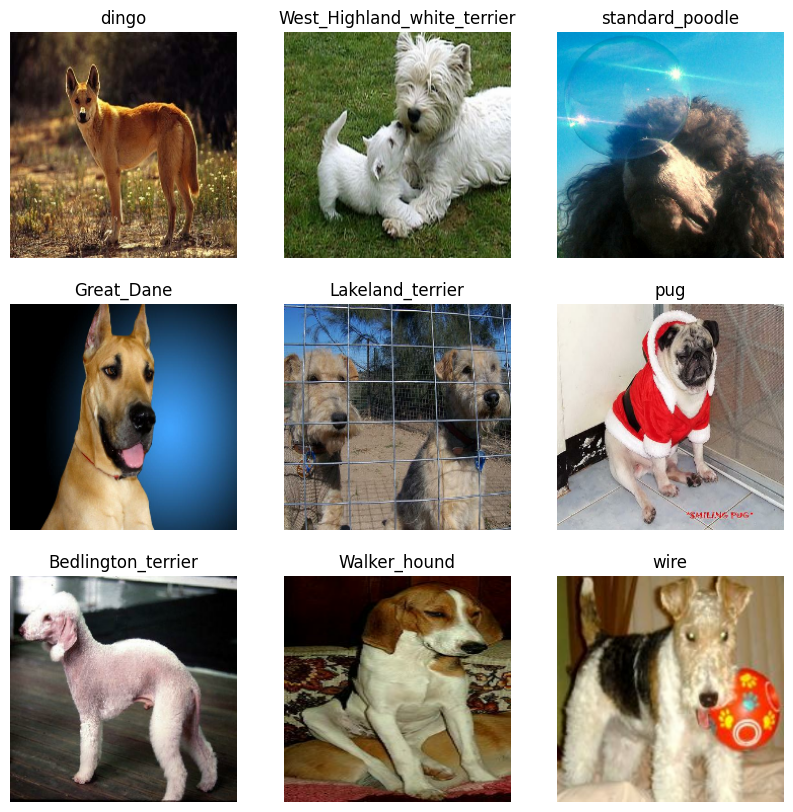

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:  ### Show image_batch's and labels_batch's shape
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


#### 1.4 Normalization

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
### normalized_train_ds
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


2023-04-04 14:50:23.482627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16464]
	 [[{{node Placeholder/_4}}]]
2023-04-04 14:50:23.482833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16464]
	 [[{{node Placeholder/_4}}]]


In [ ]:
### normalized_val_ds
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_val_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9665008


2023-04-04 14:50:27.657060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4116]
	 [[{{node Placeholder/_4}}]]
2023-04-04 14:50:27.657286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4116]
	 [[{{node Placeholder/_4}}]]


#### 1.5 To build the model via VGG19

In [ ]:
vgg19 = tf.keras.applications.vgg19.VGG19(include_top = False, input_shape = (img_width, img_height, channels), weights = 'imagenet')
vgg19.summary()  ### To show the model's architecture

80134624/80134624 [==============================] - 20s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                             

In [ ]:
model_vgg19 = Sequential()
for layer in vgg19.layers:
    layer.trainable = False      ### To turn off VGG19's trainable parameters
model_vgg19.add(vgg19)
model_vgg19.add(Flatten())      
model_vgg19.add(Dense(4096, activation = 'relu'))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Dense(1024, activation = 'relu'))
model_vgg19.add(Dense(120, activation = 'softmax'))
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_2 (Dense)             (None, 120)               123000    
                                                                 
Total params: 127,107,256
Trainable params: 107,082,872


In [ ]:
# To select the optimizer and the loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)    
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# Compile the model
model_vgg19.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])

#### 1.6 Callbacks 

In [ ]:
checkpoint = ModelCheckpoint(
    'model_vgg19.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)
csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)
reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)
callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [ ]:
### To fit the model
history = model_vgg19.fit(
    normalized_train_ds, 
    epochs = 10,
    validation_data = normalized_val_ds, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/10


/home/airi/anaconda3/envs/tf/lib/python3.9/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-04-04 14:52:53.673569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-04 14:52:54.119988: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-04-04 14:52:54.122077: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-04-04 14:52:54.122106: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
20

  1/258 [..............................] - ETA: 19:23 - loss: 5.0039 - accuracy: 0.0312

2023-04-04 14:52:56.570602: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



258/258 [==============================] - ETA: 0s - loss: 5.1680 - accuracy: 0.0342
Epoch 1: val_loss improved from inf to 3.89822, saving model to model_vgg19.h5
258/258 [==============================] - 76s 279ms/step - loss: 5.1680 - accuracy: 0.0342 - val_loss: 3.8982 - val_accuracy: 0.0904 - lr: 0.0010
Epoch 2/10
258/258 [==============================] - ETA: 0s - loss: 3.6817 - accuracy: 0.1215
Epoch 2: val_loss improved from 3.89822 to 3.45552, saving model to model_vgg19.h5
258/258 [==============================] - 71s 276ms/step - loss: 3.6817 - accuracy: 0.1215 - val_loss: 3.4555 - val_accuracy: 0.1475 - lr: 0.0010
Epoch 3/10
258/258 [==============================] - ETA: 0s - loss: 3.2320 - accuracy: 0.1845
Epoch 3: val_loss improved from 3.45552 to 3.26226, saving model to model_vgg19.h5
258/258 [==============================] - 71s 274ms/step - loss: 3.2320 - accuracy: 0.1845 - val_loss: 3.2623 - val_accuracy: 0.1893 - lr: 0.0010
Epoch 4/10
258/258 [=================

#### 1.7 Load the model

In [ ]:
load_model_vgg19 = tf.keras.models.load_model('model_vgg19.h5')

#### 1.8 Evaluate the model

In [ ]:
test_loss, test_accuracy = load_model_vgg19.evaluate(normalized_val_ds)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

65/65 [==============================] - 13s 197ms/step - loss: 3.1158 - accuracy: 0.2259
Test Loss: 3.115830421447754, Test Accuracy: 0.2259475290775299


## 2.InceptionV3

#### 2.1  Data Preprocessing - ImageDataGenerator and Data Augmentation

In [ ]:
data_dir = "Images/"  ## Dataset directory
img_width, img_height = 224, 224 
channels = 3
batch_size = 64

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255, # Normalization
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)
valid_datagen = ImageDataGenerator(
    rescale= 1./255, # Normalization
    validation_split=0.2,
)

In [ ]:
train_generator = train_datagen.flow_from_directory(  
    data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 1337
) 

Found 16508 images belonging to 120 classes.


In [ ]:
valid_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 4072 images belonging to 120 classes.


In [ ]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

#### 2.2 To build the model via InceptionV3

In [ ]:
InceptionV3 = tf.keras.applications.InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
InceptionV3.summary()

87910968/87910968 [==============================] - 24s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)      

 conv2d_199 (Conv2D)            (None, 25, 25, 32)   6144        ['average_pooling2d_18[0][0]']   
                                                                                                  
 batch_normalization_193 (Batch  (None, 25, 25, 64)  192         ['conv2d_193[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_195 (Batch  (None, 25, 25, 64)  192         ['conv2d_195[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_198 (Batch  (None, 25, 25, 96)  288         ['conv2d_198[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_210 (Conv2D)            (None, 25, 25, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_210 (Batch  (None, 25, 25, 64)  192         ['conv2d_210[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_210 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_210[0][0]']
                                                                                                  
 conv2d_208 (Conv2D)            (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_21

                                                                                                  
 activation_217 (Activation)    (None, 12, 12, 96)   0           ['batch_normalization_217[0][0]']
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_214[0][0]',         
                                                                  'activation_217[0][0]',         
                                                                  'max_pooling2d_10[0][0]']       
                                                                                                  
 conv2d_22

 mixed4 (Concatenate)           (None, 12, 12, 768)  0           ['activation_218[0][0]',         
                                                                  'activation_221[0][0]',         
                                                                  'activation_226[0][0]',         
                                                                  'activation_227[0][0]']         
                                                                                                  
 conv2d_232 (Conv2D)            (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_232 (Batch  (None, 12, 12, 160)  480        ['conv2d_232[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_242 (Conv2D)            (None, 12, 12, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_242 (Batch  (None, 12, 12, 160)  480        ['conv2d_242[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_242 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_242[0][0]']
                                                                                                  
 conv2d_243 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_243 (Batch  (None, 12, 12, 160)  480        ['conv2d_243[0][0]']             
 Normaliza

 activation_252 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_252[0][0]']
                                                                                                  
 conv2d_253 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_252[0][0]']         
                                                                                                  
 batch_normalization_253 (Batch  (None, 12, 12, 192)  576        ['conv2d_253[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_253 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_253[0][0]']
                                                                                                  
 conv2d_249 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
          

 Normalization)                                                                                   
                                                                                                  
 activation_261 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_261[0][0]']
                                                                                                  
 conv2d_258 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_262 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_261[0][0]']         
                                                                                                  
 batch_normalization_258 (Batch  (None, 12, 12, 192)  576        ['conv2d_258[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 conv2d_272 (Conv2D)            (None, 5, 5, 192)    245760      ['average_pooling2d_25[0][0]']   
                                                                                                  
 batch_normalization_264 (Batch  (None, 5, 5, 320)   960         ['conv2d_264[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_266 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_266[0][0]']
                                                                                                  
 activation_267 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_267[0][0]']
          

                                                                                                  
 activation_275 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_275[0][0]']
                                                                                                  
 activation_276 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_276[0][0]']
                                                                                                  
 activation_279 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_279[0][0]']
                                                                                                  
 activation_280 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_280[0][0]']
                                                                                                  
 batch_normalization_281 (Batch  (None, 5, 5, 192)   576         ['conv2d_281[0][0]']             
 Normaliza

In [ ]:
model_InceptionV3 = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
    
model_InceptionV3.add(InceptionV3)
model_InceptionV3.add(GlobalAveragePooling2D())
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(120,activation='softmax'))
model_InceptionV3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 120)               245880    
                                                                 
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# Compile the model
model_InceptionV3.compile(optimizer=tf.keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

#### 2.3 Callbacks 

In [ ]:
checkpoint = ModelCheckpoint(
    'model_InceptionV3.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)
csvlogger = CSVLogger(
    filename= "training_InceptionV3_csv.log",
    separator = ",",
    append = False
)
reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)
callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [ ]:
### To fit the model
history = model_InceptionV3.fit(
    train_generator, 
    epochs = 10,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/10


2023-04-04 15:39:05.709877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-04 15:40:56.683257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.78149, saving model to model_InceptionV3.h5
257/257 - 117s - loss: 1.5187 - accuracy: 0.6165 - val_loss: 0.7815 - val_accuracy: 0.7763 - lr: 0.0010 - 117s/epoch - 456ms/step
Epoch 2/10

Epoch 2: val_loss improved from 0.78149 to 0.76183, saving model to model_InceptionV3.h5
257/257 - 115s - loss: 0.9922 - accuracy: 0.7245 - val_loss: 0.7618 - val_accuracy: 0.7842 - lr: 0.0010 - 115s/epoch - 446ms/step
Epoch 3/10

Epoch 3: val_loss improved from 0.76183 to 0.75636, saving model to model_InceptionV3.h5
257/257 - 114s - loss: 0.9272 - accuracy: 0.7370 - val_loss: 0.7564 - val_accuracy: 0.7914 - lr: 0.0010 - 114s/epoch - 445ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.75636
257/257 - 114s - loss: 0.8944 - accuracy: 0.7468 - val_loss: 0.8072 - val_accuracy: 0.7845 - lr: 0.0010 - 114s/epoch - 444ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.75636
257/257 - 114s - loss: 0.8535 - accuracy: 0.7513 - val_loss: 0.8693 - val_

#### 2.4 Load the model

In [ ]:
load_model_InceptionV3 = tf.keras.models.load_model('model_InceptionV3.h5')

#### 2.5 Evaluate the model

In [ ]:
test_loss, test_accuracy = load_model_InceptionV3.evaluate(valid_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

2023-04-04 15:51:49.517610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


64/64 [==============================] - 6s 85ms/step - loss: 0.7589 - accuracy: 0.7905
Test Loss: 0.7589378952980042, Test Accuracy: 0.7905206084251404


#### 2.6 Predict

In [ ]:
prediction = np.argmax(load_model_InceptionV3.predict(valid_generator), axis = 1)

2023-04-04 15:55:01.951210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


64/64 [==============================] - 6s 83ms/step


In [ ]:
for image, label  in valid_generator:
    true_label = label
    true_image = image
    break

In [ ]:
true_image_prediction = np.argmax(load_model_InceptionV3.predict(true_image[10:15]), axis = 1)
print(true_image_prediction)

1/1 [==============================] - 1s 897ms/step
[ 32  27  48  28 119]


In [ ]:
index = np.where(true_label[10:15][0:5] == 1)[1]

In [ ]:
index

array([ 32,  27,  48,  28, 119])

In [ ]:
# tf.distribute.MirroredStrategy()
# strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

# To build architecture from scratch
### 1.case

In [ ]:
# class MyModel(Model):
#     def __init__(self):
#         super(MyModel, self).__init__()
#         self.conv1 = Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding = 'same')
#         self.conv2 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'same')
#         self.conv3 = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding = 'same')
#         self.pooling = MaxPooling2D(pool_size = (2, 2), strides = 2)
#         self.flatten = Flatten()
#         self.d1 = Dense(1024, activation='relu')
#         self.d2 = Dense(512, activation='relu')
#         self.dense_output = Dense(120, activation = 'softmax')  

#     def call(self, x):
#         conv1_1 = self.conv1(x)
#         pool = self.pooling(conv1_1)
#         conv2_2 = self.conv2(pool)
#         pool = self.pooling(conv2_2)
#         conv3_3 = self.conv3(pool)
#         pool = self.pooling(conv3_3)
#         flatten_1  = self.flatten(pool)
#         hidden_1 = self.d1(flatten_1)
#         hidden_2 = self.d2(hidden_1)
#         return self.dense_output(hidden_2)

# # Create an instance of the model
# model = MyModel()


### 2-case

In [ ]:
# class MyModel(Model):
#     def __init__(self):
#         super(MyModel, self).__init__()
#         self.conv1 = Conv2D(96, 11,  activation='relu', strides = (4, 4),  padding = 'valid')
#         self.conv2 = Conv2D(256, 5, activation='relu', strides = (1, 1),  padding = 'same')
#         self.conv3 = Conv2D(384, 3, activation='relu', strides = (1, 1),  padding = 'same')
#         self.conv4 = Conv2D(384, 3, activation='relu', strides = (1, 1),  padding = 'same')
#         self.conv5 = Conv2D(384, 3, activation='relu', strides = (1, 1),  padding = 'same')
        
#         self.pooling = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))
#         self.drop = Dropout(rate = 0.5)
#         self.flatten = Flatten()
#         self.d1 = Dense(4096, activation='relu')
#         self.d2 = Dense(4096, activation='relu')
#         self.dense_output = Dense(120, activation = 'softmax')  

#     def call(self, x):
#         conv1_1 = self.conv1(x)
#         pool = self.pooling(conv1_1)
#         dropout = self.drop(pool)

#         conv2_2 = self.conv2(dropout)
#         pool = self.pooling(conv2_2)
#         dropout = self.drop(pool)
        
#         conv3_3 = self.conv3(dropout)
#         conv4_4 = self.conv4(conv3_3)
#         conv5_5 = self.conv5(conv4_4)
#         pool = self.pooling(conv5_5)
#         dropout = self.drop(pool)
          
#         flatten_1  = self.flatten(dropout)
#         hidden_1 = self.d1(flatten_1)
#         hidden_2 = self.d2(hidden_1)
#         return self.dense_output(hidden_2)

# # Create an instance of the model
# model = MyModel()

### 3-case

#### 3.1 VGG19 architecture

In [ ]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.conv1 = Conv2D(64, kernel_size = (3, 3),  activation='relu', padding = 'same')
        self.conv1_1 = Conv2D(64, kernel_size = (3, 3),  activation='relu', padding = 'same')
        
        self.conv2 = Conv2D(128, kernel_size = (3, 3),  activation='relu', padding = 'same')
        self.conv2_1 = Conv2D(128, kernel_size = (3, 3),  activation='relu', padding = 'same')
        
        self.conv3 = Conv2D(256, kernel_size = (3, 3),  activation='relu', padding = 'same')
        self.conv3_1 = Conv2D(256, kernel_size = (3, 3),  activation='relu', padding = 'same')
        self.conv3_2 = Conv2D(256, kernel_size = (3, 3),  activation='relu', padding = 'same')
        self.conv3_3 = Conv2D(256, kernel_size = (3, 3),  activation='relu', padding = 'same')
        
        self.conv4 = Conv2D(512, kernel_size = (3, 3),  activation='relu', padding = 'same')
        self.conv4_1 = Conv2D(512, kernel_size = (3, 3),  activation='relu', padding = 'same')
        self.conv4_2 = Conv2D(512, kernel_size = (3, 3),  activation='relu', padding = 'same')
        self.conv4_3 = Conv2D(512, kernel_size = (3, 3),  activation='relu', padding = 'same')
        
        self.conv5 = Conv2D(512, kernel_size = (3, 3),  activation='relu', padding = 'same')
        self.conv5_1 = Conv2D(512, kernel_size = (3, 3),  activation='relu', padding = 'same')
        self.conv5_2 = Conv2D(512, kernel_size = (3, 3),  activation='relu', padding = 'same')
        self.conv5_3 = Conv2D(512, kernel_size = (3, 3),  activation='relu', padding = 'same')
        
        self.pooling = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same')
        
        self.drop = Dropout(rate = 0.2)
        self.flatten = Flatten()
#         self.dense1 = Dense(4096, activation='relu')
#         self.dense2 = Dense(2048, activation='relu')
        self.dense3 = Dense(1024, activation='relu')
#         self.dense4 = Dense(512, activation='relu')
        self.dense_output = Dense(120, activation = 'softmax')

    def call(self, x):
        
        # Block 1
        cnn1_1 = self.conv1(x)
        cnn1_2 = self.conv1_1(cnn1_1)
        pool = self.pooling(cnn1_2)

        
        #  Block 2
        cnn2_1 = self.conv2(pool)
        cnn2_2 = self.conv2_1(cnn2_1)
        pool = self.pooling(cnn2_2)
        
        # Block 3
        cnn3_1 = self.conv3(pool)
        cnn3_2 = self.conv3_1(cnn3_1)
        cnn3_3 = self.conv3_2(cnn3_2)
        cnn3_4 = self.conv3_3(cnn3_3)
        pool = self.pooling(cnn3_4)
        
        # Block 4
        cnn4_1 = self.conv4(pool)
        cnn4_2 = self.conv4_1(cnn4_1)
        cnn4_3 = self.conv4_2(cnn4_2)
        cnn4_4 = self.conv4_3(cnn4_3)
        pool = self.pooling(cnn4_4)
        
        # Block 5
        cnn5_1 = self.conv5(pool)
        cnn5_2 = self.conv5_1(cnn5_1)
        cnn5_3 = self.conv5_2(cnn5_2)
        cnn5_4 = self.conv5_3(cnn5_3)
        pool = self.pooling(cnn5_4)
        
        # Block 6   
        flatten_1  = self.flatten(pool)
#         hidden_1 = self.dense1(flatten_1) 
#         drop_1 = self.drop(hidden_1)
#         hidden_2 = self.dense2(drop_1)
#         drop_2 = self.drop(hidden_2)
        hidden_3 = self.dense3(flatten_1)
#         hidden_4 = self.dense4(hidden_3)
        return self.dense_output(hidden_3)

# Create an instance of the model
model = MyModel()

In [ ]:
# To select the optimizer and loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
# Define the checkpoint directory and file name
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# Define the callback for saving the model
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

#### 3.2 Train step

In [ ]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

#### 3.3 Test step

In [ ]:
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

#### 3.4 To fit the model

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in val_ds:
        test_step(test_images, test_labels)
        
    # Save the model after each epoch
    model.save_weights(checkpoint_prefix.format(epoch=epoch)) 

    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
    )

Epoch 1, Loss: 8.599831581115723, Accuracy: 1.0386297702789307, Test Loss: 4.7828688621521, Test Accuracy: 1.0204081535339355
Epoch 2, Loss: 4.822229862213135, Accuracy: 1.1904761791229248, Test Loss: 4.784078598022461, Test Accuracy: 1.0204081535339355
Epoch 3, Loss: 4.781360149383545, Accuracy: 1.2755101919174194, Test Loss: 4.783656597137451, Test Accuracy: 1.0204081535339355
Epoch 4, Loss: 4.780576229095459, Accuracy: 1.2755101919174194, Test Loss: 4.783255100250244, Test Accuracy: 1.0204081535339355
Epoch 5, Loss: 4.780516147613525, Accuracy: 1.2755101919174194, Test Loss: 4.782993793487549, Test Accuracy: 1.0204081535339355
Epoch 6, Loss: 4.7801361083984375, Accuracy: 1.2755101919174194, Test Loss: 4.783297061920166, Test Accuracy: 1.0204081535339355
Epoch 7, Loss: 4.780270099639893, Accuracy: 1.2755101919174194, Test Loss: 4.7834062576293945, Test Accuracy: 1.0204081535339355
Epoch 8, Loss: 4.780150890350342, Accuracy: 1.2755101919174194, Test Loss: 4.78366231918335, Test Accura

In [ ]:
# Epoch 2, Loss: 20.1428165435791, Accuracy: 0.9961127042770386 for 1-case. This case is bad 
# Epoch 2, Loss: 4.781538486480713, Accuracy: 1.2633624076843262 for 2-case. 
# Epoch 30, Epoch 30, Loss: 4.778024196624756, Accuracy: 1.2876579761505127 for 2-case. 

In [ ]:
model.summary()

Model: "my_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_362 (Conv2D)         multiple                  1792      
                                                                 
 conv2d_363 (Conv2D)         multiple                  36928     
                                                                 
 conv2d_364 (Conv2D)         multiple                  73856     
                                                                 
 conv2d_365 (Conv2D)         multiple                  147584    
                                                                 
 conv2d_366 (Conv2D)         multiple                  295168    
                                                                 
 conv2d_367 (Conv2D)         multiple                  590080    
                                                                 
 conv2d_368 (Conv2D)         multiple                  5

In [ ]:
os.listdir('./training_checkpoints')

['ckpt_8.index',
 'ckpt_1.index',
 'ckpt_1.data-00000-of-00001',
 'ckpt_2.data-00000-of-00001',
 'ckpt_0.index',
 'ckpt_4.data-00000-of-00001',
 'ckpt_5.index',
 'ckpt_8.data-00000-of-00001',
 'ckpt_2.index',
 'ckpt_6.index',
 'ckpt_4.index',
 'ckpt_3.index',
 'checkpoint',
 'ckpt_5.data-00000-of-00001',
 'ckpt_3.data-00000-of-00001',
 'ckpt_9.data-00000-of-00001',
 'ckpt_7.index',
 'ckpt_9.index',
 'ckpt_7.data-00000-of-00001',
 'ckpt_6.data-00000-of-00001',
 'ckpt_0.data-00000-of-00001']

In [ ]:
# Restore the latest checkpoint
latest_checkpoint = tf.train.latest_checkpoint('./training_checkpoints')
if latest_checkpoint:
    print(model.load_weights(latest_checkpoint))

In [ ]:
# save the model in SavedModel format as tf 
model.save('my_model', save_format='tf')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
# load the model
loaded_model = tf.keras.models.load_model('my_model')

In [ ]:
a = loaded_model.predict(val_ds)

65/65 [==============================] - 13s 196ms/step


In [ ]:
np.argmax(a, axis = 1)

In [ ]:
k = loaded_model.predict(image_batch[0:1])

In [ ]:
np.argmax(k, axis = 1)